<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

#### Logbook

In [ ]:
# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> 1, 2, 3, 4, 5
# 06/06/23 -> 6 - Correlacion de Residuos
# 17/06/23 -> 7 - Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab
# 20/06/23 -> R Magic

In [ ]:


# Autor: Andres Montes de Oca

# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels


# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
sys.setrecursionlimit(50000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## R Magic in Google Colab

In [ ]:
# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# activate R magic
%load_ext rpy2.ipython

# Import rpy2 for dataframe conversion
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import globalenv


# ###### Pandas DataFrames and Series conversion ########
# # Cargamos un DataSet cualquira en Python, para que no de error
# data_P = sns.load_dataset('iris')
# Serie = data_P['petal_length']

# # Convert the Python DataFrame to the R dataframe
# %R -i data_P

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_R = ro.conversion.py2rpy(data_P)
# # Create a variable name in R's Global Environment
# globalenv['data_R'] = data_R

# # Convert Python Series to R vectors
# vec_float_R = ro.vectors.FloatVector(Serie)
# # vec_int_R = ro.vectors.IntVector(Serie)
# # vec_str_R = ro.vectors.StrVector(Serie)
# globalenv['vec_float_R'] = vec_float_R

# # Convert R datadrame/vector to Python DataFrame/Vector
# %R -o data_R

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_P = ro.conversion.rpy2py(data_R)

# # Importar R-Functions a Python como Objetos(sin uso)
# shapiro_test = ro.r('shapiro.test')
# result = shapiro_test(vec_float_R)

#### Instalaciones Individuales en Bash

In [ ]:
# system(sudo apt install libgsl-dev)

#### Instalacion de Librerias para R en Google Colab

In [ ]:
%%R

### MVN Henze-Zirkler Test ###
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

### Wald Test ###
# install.packages('aod')

### QQ Plot ###
# install.packages('car')

### Durbin_Watson Test ###
# install.packages('lmtest')


####################################
### Installation Status ###
# print(system.file(package='MVN'))

## Cargas de Datasets from Google Drive

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG

######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP

# # Convert the Python DataFrame to the R dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataP_R = ro.conversion.py2rpy(dataP)
# # Create a variable name in R's Global Environment
# globalenv['dataP_R'] = dataP_R

######################################################
# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
model_cars = smf.ols('dist ~ speed', data=dataC).fit()
%R -i dataC

######################################################
# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')
%R -i dataU

######################################################
# Iris(Python)
dataI = sns.load_dataset('iris')

# # Iris(R) -> DataFrame to dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataI_R = ro.conversion.py2rpy(dataI.drop(columns='species'))
# # Create a variable name in R's global environment
# globalenv['dataI_R'] = dataI_R

# # Serie to Vector
# x_R = ro.FloatVector(dataI['petal_length'])
# w_R = ro.FloatVector(dataI['petal_width'])
# globalenv['x_R'] = x_R
# globalenv['w_R'] = w_R
%R -i dataI

######################################################
# Gorriones
id = '15G6jIOMiuWaTs-qy7eUXwhED4delBMl6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('gorriones.xlsx')
dataO = pd.read_excel('gorriones.xlsx')
dataO.rename(columns=
            {'largototal':'Largo', 'extension ':'Alas', 'cabeza':'Cabeza',
             'humero':'Pata', 'esternon':'Cuerpo', 'sobrevida ':'Target'},
            inplace=True)
%R -i dataO


## 1) Linear Relationship
Relationship between independent var (x) and depedent var (y) is linear

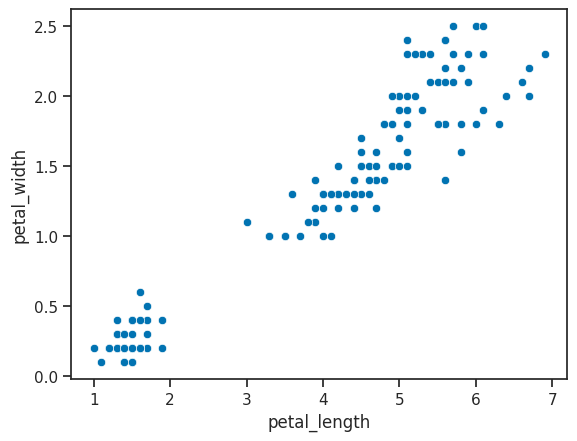

In [ ]:
sns.scatterplot(data=dataI, x='petal_length', y='petal_width')
plt.show()

# Transformmations for making relationships linear. Polynomial or Exponential for any of both

## 2) Multicollonearity
Eeach independent variable should be independent from other independent variables

,n,r,CI95%,p-val,BF10,power
pearson,150,0.962865,"[0.95, 0.97]",4.675004e-86,1.113e+82,1.0


,n,r,CI95%,p-val,power
spearman,150,0.937667,"[0.91, 0.95]",8.156597e-70,1.0


<Axes: >

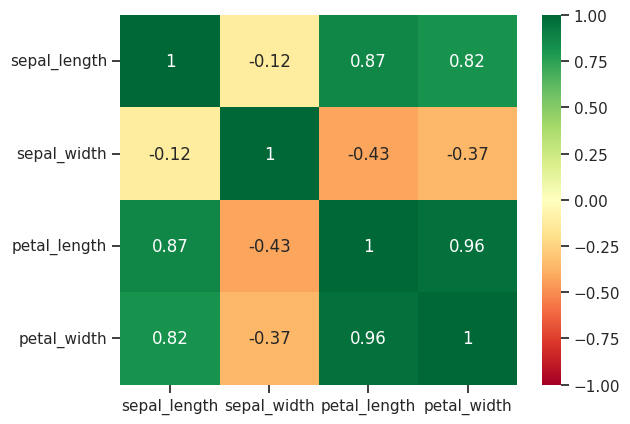

In [ ]:
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='spearman')) # Cuando no se cumplen los supuestos de Pearson
display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

## 3) Bi-Variate Normality
Multivariate Normality in Variables

,W,pval,normal
sepal_width,0.984917,0.101126,True


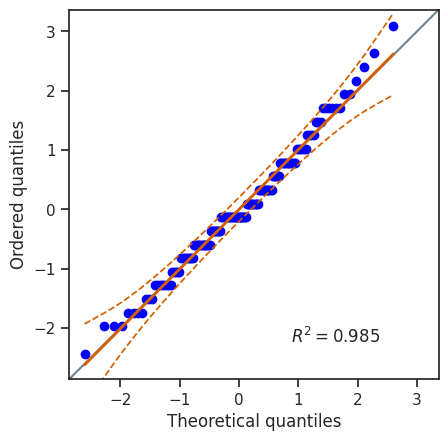

HZResults(hz=2.3363942003154383, pval=4.141311629927849e-19, normal=False)


In [ ]:
# Tests analiticos para Single
display(pg.normality(dataI['sepal_width'])) # Shapiro Test(single Var), H0 -> Normal Dist

# Otros tests
# st.anderson(dataI['sepal_width'], dist='norm') # Anderson-Darling SciPy
# st.kstest(dataI['sepal_width'], 'norm')# Kolmogorov-Smirnov SciPy

# Test grafico para Single
pg.qqplot(dataI['sepal_width']) # QQ Plot
plt.show()

# Test analitico para Multi
print(pg.multivariate_normality(dataI.drop(columns='species'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist

#### R Magic

In [ ]:
# Otros Tests en R
%%R

# library(car)
# qqPlot(dataI$sepal_width)

# library(MVN)
# mvn_result <- mvn(dataI, mvnTest = 'hz')
# print(mvn_result)

NULL


## X) Linear Regression Models

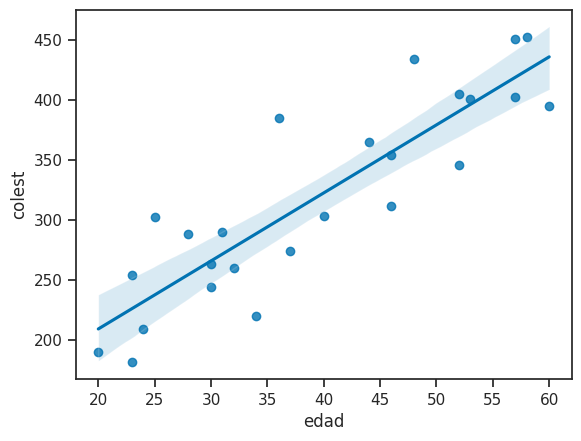

In [ ]:
# LRM en Python
dataP = sm.add_constant(dataP)
model_colest = smf.ols('colest ~ edad', data=dataP).fit()

sns.regplot(data=dataP, x='edad', y='colest')
plt.show()

#### R Magic

In [ ]:
# LRM en R
%%R

model_colest_R = lm('colest ~ edad', data=dataP)
# print(summary(model_colest_R))
# print(anova(model_colest_R))

# Bandas de Prediccion
predichos <- predict(object=model_colest_R, interval='prediction', level=0.95)
nuevos_datos <- data.frame(predichos, dataP)

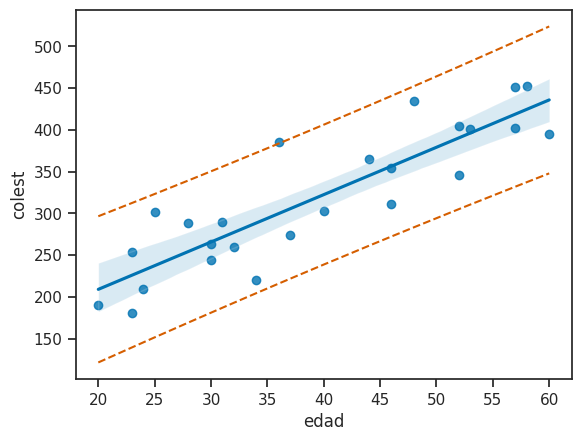

In [ ]:
# Exporto a Python
%R -o nuevos_datos

# Grafico
sns.regplot(data=nuevos_datos, x='edad', y='colest')
sns.lineplot(data=nuevos_datos, x='edad', y='lwr', linestyle='--', color='r')
sns.lineplot(data=nuevos_datos, x='edad', y='upr', linestyle='--', color='r')
plt.show()

## Wald Test (revisar)
Mide si la Variable X es lo suficientemente significativa como para explicar la Y

#### R Magic

In [ ]:
# # Wald Test -> Significatividad de cada Variable
# %%R

# library(aod)

# # Generamos el Modelo
# model_gorr = lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=dataO)
# print(summary(model_gorr))

# # Wald Test para indentificar variables significativas
# wald.test(Sigma = vcov(model_gorr), b = coef(model_gorr), Terms = 4) # Cuerpo| H0: Coef = 0 (Var no significativa)



Call:
lm(formula = "Largo ~ Alas + Cabeza + Pata + Cuerpo", data = dataO)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9390 -1.4553 -0.1746  1.7859  5.4613 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  28.2429    16.7634   1.685  0.09911 . 
Alas          0.3137     0.1063   2.950  0.00508 **
Cabeza        0.9857     0.6623   1.488  0.14382   
Pata          0.2519     1.1598   0.217  0.82904   
Cuerpo        0.8824     0.4299   2.053  0.04607 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.315 on 44 degrees of freedom
Multiple R-squared:  0.632,	Adjusted R-squared:  0.5985 
F-statistic: 18.89 on 4 and 44 DF,  p-value: 4.197e-09

Wald test:
----------

Chi-squared test:
X2 = 0.047, df = 1, P(> X2) = 0.83


## 4) Residuals Normality With 0 Mean
Model residuals should follow a normal distribution, with 0 as mean

In [ ]:
# Primero hay que generar el Modelo de Regresion Lineal
display(pg.normality(model_colest.resid))
print('Mean:', model_colest.resid.mean())

# If distribution is not normal, regression results will be biased
# and it may highlight that there are outliers or other assumptions being violated

## 5) Residuals Variance (Homosedasticity)
The variance of residual is the same for any value of x

In [ ]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=model_colest.predict(), y=model_colest.resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

# Analitico (Breusch-Pagan Test) -> H0: Residuos Homocedasticos
BP, p_value, _, _ =sm.stats.het_breuschpagan(model_colest.resid, model_colest.model.exog)
print('Estadistico BP y p-value:', BP, p_value)

# R Magic
# %R bptest(model_colest_R)

NameError: ignored

#### R Magic

In [ ]:
%%R

bptest(model_colest_R)


	studentized Breusch-Pagan test

data:  model_colest_R
BP = 0.15821, df = 1, p-value = 0.6908



## 6) Correlacion de Residuos
Aleatoriedad en el orden de las observacioens

In [ ]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=dataP.index, y=model_colest.resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Durbin-Watson Test: 2=No Correlacion (Independecia?)| 0=Correlacion Pos | 4=Correlacion Neg
print('Durbin-Watson:', sm.stats.durbin_watson(model_colest.resid)) # Sin validacion Estadistica

NameError: ignored

#### R Magic

In [ ]:
# %%R
# library(lmtest)
# dwtest(model_colest_R, alternative='two.sided', iterations=1000) #H0 No Correlacion


	Durbin-Watson test

data:  model_colest_R
DW = 1.7831, p-value = 0.6349
alternative hypothesis: true autocorrelation is not 0



## 7) Transformacion Box-Cox (pendiente IC e IP)
Cuando los residuos no siguen una distribucion Normal, transformamos la y

In [ ]:
# Verificamos la Normalidad de los residuos
print(st.shapiro(model_cars.resid))
data = dataC
y = data['dist']

# Box-Plot Transformation - Calculo Lambda
maxlog = st.boxcox(y)[1]
st.boxcox_normplot(y, -2, 2, plt)
plt.axvline(maxlog, color='red')
plt.show()

# Transfomracion: Si Lambda  = 0 -> np.log10(y) | y**Lambda
y_trans = pd.Series(y**.5, name='y_trans')
# No olvidarse de anti-transformar para los IC(10**predicted)

# Generamos el nuevo Dataset con la y transformada
data = pd.concat([data, y_trans], axis=1)

# Generamos el nuevo modelo con la y_transformada
model_cars_trans = smf.ols('y_trans ~ speed', data=data).fit()

# Verificamos la nueva normalidad de los residuos
print(pg.normality(model_cars_trans.resid))